# Part5: Coincidence detection with AMPA-like and NMDA-like synapses

Coincidence detection can be emulated on Dynap-SE1 by combining the AMPA-like (DPI fast) and the NMDA-like (DPI slow) synapse.

Let's start with importing Brian2:

In [1]:
from brian2 import *
from DynapSE import DynapSE
from parameters import constants

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from parameters.set_params import set_params

# Display plots inside Jupyter cell
%matplotlib inline 
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90 
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

from equations.dynapse_eq import *
from parameters.dynapse_param import *

# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

INFO       Cache size for target "cython": 1046 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/nicoletta/.cython/brian_extensions" directory. [brian2]


## Input Spike Train

Let's generate a sequence of input spikes by combining two spike trains:
- input pulses via the **AMPA** synapse: regular spike train with rate=2Hz 
- input pulses via the **NMDA** synapse: generated from the first spike train, by regularly shifting the i-th spike with respect to the i-th AMPA spike by 10ms*i.

Run the next cell to visualize the resulting input spike train:

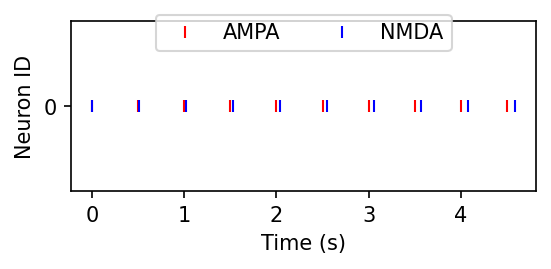

In [2]:
num_spikes = 10
rate = 2            # Hz
inp_duration = num_spikes/rate # second
spikes = np.zeros(int(inp_duration*1000))
dt = int(1000/rate)
end = int(inp_duration*1000)
spikes[0:end:dt] = 1.0

spike_timing_ampa = np.where(spikes==1)[0] * ms # Timing of spikes
spike_timing_nmda = np.array([spike_timing_ampa[idx]/ms+idx*10 for idx in range(len(spike_timing_ampa))])*ms

neuron_indices_nmda = np.zeros(len(spike_timing_nmda)) # ID of spike sources
neuron_indices_ampa = np.zeros(len(spike_timing_ampa)) # ID of spike sources

# Spike Generator
input_spike_generator_ampa = SpikeGeneratorGroup(1, indices=neuron_indices_ampa, times=spike_timing_ampa, name='InpAMPA')  
input_spike_generator_nmda = SpikeGeneratorGroup(1, indices=neuron_indices_nmda, times=spike_timing_nmda, name='InpNMDA')  

# Plot
plt.figure(figsize=(4,1.5),dpi=150)
plt.plot(spike_timing_ampa, neuron_indices_ampa, 'r|', label='AMPA')
plt.plot(spike_timing_nmda, neuron_indices_nmda, 'b|', label='NMDA')
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1))
plt.xlabel("Time (s)")
plt.ylabel("Neuron ID")
plt.ylim(-0.25, .25)
plt.yticks([0])
plt.show()

## DPI Coincidence detector
Let's now create our **DPI coincidence detector** by connecting both AMPA and NMDA synapse to one DPI neuron

In [3]:
network = Network() # Instantiate a Brian2 Network
chip = DynapSE(network) # Instantiate a Dynap-SE1 chip implementing neural and synaptic silicon dynamics

# DPI neuron
DPI_neuron  = chip.get_neurons(1, 'Core_1') # Allocate single DPI neuron from Core 1

# DPI synapses
DPI_AMPA_synapse = chip.add_connection(input_spike_generator_ampa, DPI_neuron, synapse_type='AMPA') # Define a slow excitatory synapse
DPI_NMDA_synapse = chip.add_connection(input_spike_generator_nmda, DPI_neuron, synapse_type='NMDA')
chip.connect(DPI_NMDA_synapse, True)
chip.connect(DPI_AMPA_synapse, True)

# Monitors
mon_neuron_input_ampa  = SpikeMonitor(input_spike_generator_ampa, name='mon_neuron_input_ampa')
mon_neuron_input_nmda  = SpikeMonitor(input_spike_generator_nmda, name='mon_neuron_input_nmda')
mon_synapse_nmda  = StateMonitor(DPI_NMDA_synapse, 'I_syn_nmda', record=[0])
mon_synapse_ampa  = StateMonitor(DPI_AMPA_synapse, 'I_syn_ampa', record=[0])
mon_neuron_state  = StateMonitor(DPI_neuron, 'Imem', record=True)
mon_neuron_vmem  = StateMonitor(DPI_neuron, 'Vmem', record=True)
mon_neuron_I_syn_nmda  = StateMonitor(DPI_NMDA_synapse, 'I_syn_nmda_dp', record=True)
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')

# Add every instance we created to Brian network, so it will include them in the simulation
network.add([input_spike_generator_ampa, input_spike_generator_nmda, DPI_neuron, DPI_NMDA_synapse, 
             DPI_AMPA_synapse, mon_neuron_input_ampa, mon_neuron_input_nmda, mon_synapse_nmda, 
             mon_synapse_ampa, mon_neuron_output, mon_neuron_state, mon_neuron_vmem, mon_neuron_I_syn_nmda])

1 neurons are allocated from Core_1.


## Parameter tuning

We will now explore how to set the DPI neuron and synapse parameters such that 
the coincidence detector will respond only to 'coincident' input spikes, i.e. such that the
AMPA-NMDA inter-spike-interval ISI falls within a specific time window.

### 1. Time constants

Let's start by fixing the synaptic time constants (i.e. the DPI leakage current). To emulate the biological AMPA and NMDA dynamics, we will set the DPI synapse leakage such that $\tau_{AMPA}<\tau_{NMDA}$. 

In [4]:
dynapse_param["I_tau_syn_nmda"] = 1 *pA #.5
dynapse_param["I_tau_syn_ampa"] = 10 *pA

Which correspond to the following time constants:

In [5]:
kappa = (constants.kappa_n + constants.kappa_n) / 2
tau_ampa = dynapse_param['C_syn_ampa'] * constants.Ut /(constants.kappa_p * dynapse_param["I_tau_syn_ampa"])
tau_nmda = dynapse_param['C_syn_nmda'] * constants.Ut /(constants.kappa_p * dynapse_param["I_tau_syn_nmda"])
tau = (dynapse_param['Cmem'] * constants.Ut) / (kappa * dynapse_param['Itau'])

print('Leak AMPA {} A - Tau AMPA: {} ms'.format(dynapse_param["I_tau_syn_ampa"], np.round(tau_ampa*1e3,2)))
print('Leak NMDA {} A - Tau NMDA: {} ms'.format(dynapse_param["I_tau_syn_nmda"], np.round(tau_nmda*1e3,2)))

Leak AMPA 1e-11 A - Tau AMPA: 5.68 ms
Leak NMDA 1e-12 A - Tau NMDA: 56.82 ms


In order to increase the sensitivity of the coincidence detector neuron to short temporal delays, we will set the neuron time constant equal to the AMPA synapse tau. 

In [6]:
dynapse_param['Itau'] = dynapse_param["I_tau_syn_ampa"]

### 2. DPI gain

**Neuron:** When the approximation to a first order differential equation holds (see part1 for more details), the steady state value of the DPI is $$I_{mem, ss}=\frac{I_g I_{in}}{I_{\tau}}$$.

If we set the $I_g = I_{tau}$, the only parameter left that controls the gain of the $I_mem$ is the $I_{in}$. Therefore, we chose:

In [7]:
dynapse_param['Ith'] = dynapse_param['Itau']

**Synapse**

Similarly for the synapse, if $I_{syn}  \gg I_g$, the solution of the differential equation in steady state becomes:
$$I_{syn, ss}=\frac{I_g I_{w}}{I_{\tau}}$$

If we fix the ratio $I_g/I_{\tau}$, the only parameter left that controls the synaptic strength is the $I_w$

In [8]:
dynapse_param["I_g_syn_nmda"] = dynapse_param["I_tau_syn_nmda"]
dynapse_param["I_g_syn_ampa"] = dynapse_param["I_tau_syn_ampa"]

### 3. Synaptic weights

Let's start by setting the NMDA synaptic weight, e.g.

In [9]:
dynapse_param['I_wo_syn_nmda'] = 100*nA 

which leads to the DP I-V characteristic:

Text(0.5, 1.0, 'DP I-V')

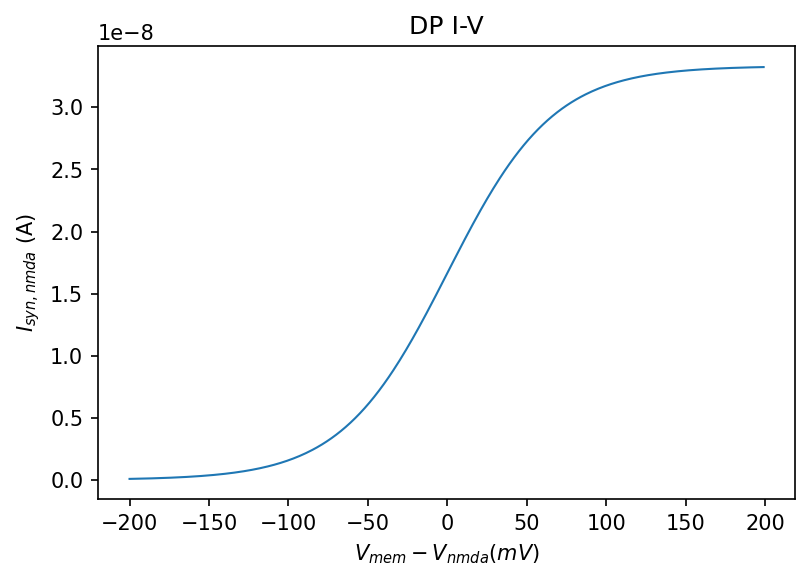

In [10]:
list_vmem_minus_vnmda = np.arange(-200,200)*mV 

w_nmda=dynapse_param['I_wo_syn_nmda']
f = plt.figure(dpi=150)

EPSC_nmda = dynapse_param['I_wo_syn_nmda']*dynapse_param['I_g_syn_nmda']/(dynapse_param["I_tau_syn_nmda"]*((dynapse_param["I_g_syn_nmda"]/constants.Io)+1))

# Sigmoid
i_syn_nmda = EPSC_nmda/(1 + np.exp(-constants.kappa_n*list_vmem_minus_vnmda/constants.Ut))
p = plt.plot(list_vmem_minus_vnmda/mV, i_syn_nmda/nA*1e-9, linewidth=1) 
plt.xlabel('$V_{mem}-V_{nmda} (mV)$')
plt.ylabel('$I_{syn,nmda}$ (A)')
plt.title('DP I-V')

From the DP characteristic we infer that, for the DP to act as a voltage-gating mechanism, and given the selected NMDA weight, we need the voltage $V_{mem}-V_{nmda}$ to span across a range of at least 150 mV, wherein the synaptic NMDA current switches between I_syn and 0 mV.

In other words, if we want the coincidence detector to respond only to 'close enough' AMPA-NMDA inter-spike-interval, we can exploit the EPSP due to the AMPA spike as a trigger that offsets the voltage $V_{mem}$ by the expected amount (~150 mV in this case).

What is the right AMPA synaptic strength that yields such EPSP amplitude?

Let's run the simulation (with NMDA synaptic weight turned off) to plot the EPSP as a function of the AMPA synaptic weight. 

In [11]:
try:
    network.restore()
except KeyError:
    # Network state has not been stored yet
    network.store()
    
# Input parameters: ===============================================================================================================                                         
dynapse_param['I_wo_syn_nmda'] = 0*nA
# =================================================================================================================================
for core in chip.cores:
    set_params(core.neurons, dynapse_param)

# Simulation
duration = 200 * ms
list_w_ampa = np.linspace(1,10,4)
dict_iampa = {}
dict_imem = {}
dict_vmem = {}
for param in list_w_ampa:
    print('w_ampa: ', param)
    dynapse_param['I_wo_syn_ampa'] = param*nA
        
    for core in chip.cores:
        set_params(core.neurons, dynapse_param)
        
    # Simulation
    duration = 200* ms # look at first input spike only

    # Run
    network.run(duration)
    
    dict_iampa[param] = (mon_synapse_ampa.t/ms, mon_synapse_ampa.I_syn_ampa[0])
    dict_imem[param] = (mon_neuron_state.t/ms, mon_neuron_state.Imem[0])
    dict_vmem[param] = (mon_neuron_vmem.t/ms, mon_neuron_vmem.Vmem[0])   
    network.restore()

w_ampa:  1.0
w_ampa:  4.0
w_ampa:  7.0
w_ampa:  10.0


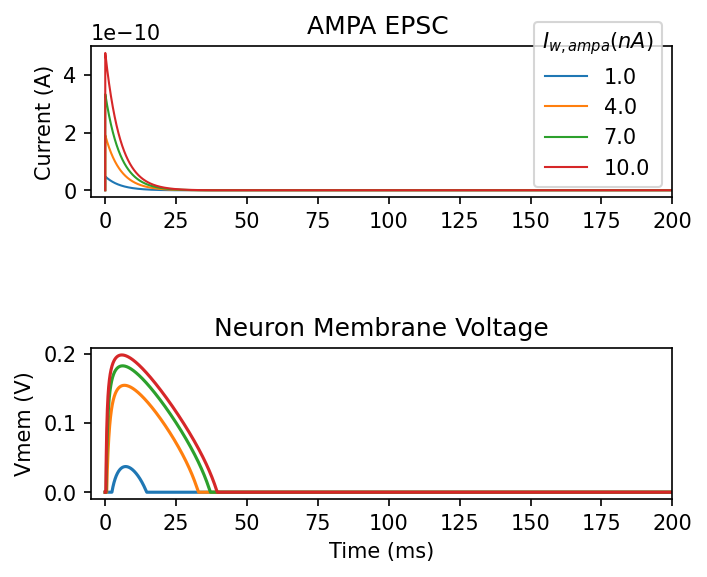

In [13]:
f = plt.figure(figsize=(5,4),dpi=150)
plt.subplots_adjust(hspace=1, wspace=.8)
tstart=0
tend=int(duration*ms)

for key in dict_iampa.keys():
    plt.subplot(212)
    plt.plot(dict_vmem[key][0], dict_vmem[key][1], linewidth=1.5)
    ylim = plt.ylim()
    plt.title('Neuron Membrane Voltage')
    plt.ylabel('Vmem (V)')
    plt.xlim(-5, duration/ms)
    plt.xlabel('Time (ms)') 
    
    # Input Spikes 
    plt.subplot(211)
    plt.plot(dict_iampa[key][0], dict_iampa[key][1], linewidth=1, label=str(key))
    plt.xlim(-5, duration/ms)
    plt.ylabel('Current (A)')
    plt.title('AMPA EPSC ')
    
plt.legend(title='$I_{w,ampa} (nA)$')

This result indicates that in order to elicit the expected increase in membrane voltage, which triggers the on-off switching behavior of the differential pair, we should use an input $I_{w,ampa}$ current of at least 6nA. Thus:

In [14]:
dynapse_param['I_wo_syn_ampa'] = 6 * nA 

At this point, what is left to set is the value of the $V_{nmda}$. Let's start with **$V_{nmda}$ = 400 mV**. This voltage should be large enough, compared to the peak of the AMPA EPSP that, even if the NMDA input comes right after the AMPA spike, the fraction of the input synaptic current actually injected into the DPI neuron will not be large enough to elicit an output spike.

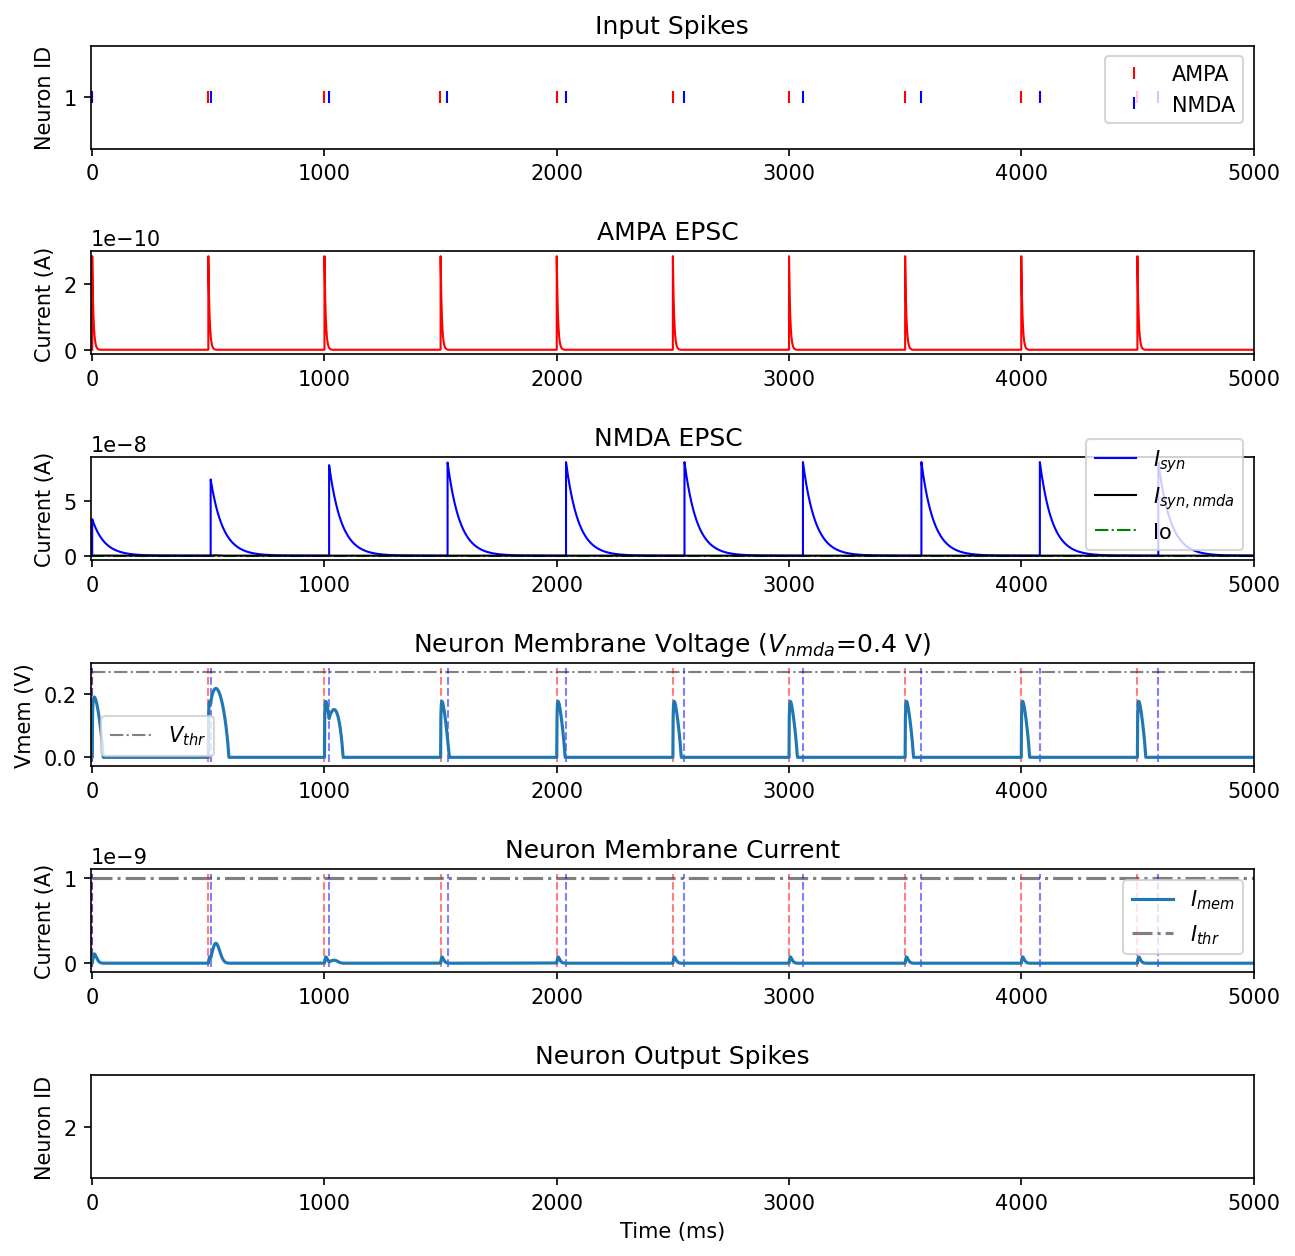

In [15]:
try:
    network.restore()
except KeyError:
    # Network state has not been stored yet
    network.store()
    
# Input parameters: ===============================================================================================================
dynapse_param["I_tau_syn_nmda"] = 1 *pA #.5
dynapse_param["I_tau_syn_ampa"] = 10 *pA    
dynapse_param['Itau'] = 10 *pA
dynapse_param["I_g_syn_nmda"] = dynapse_param["I_tau_syn_nmda"]
dynapse_param["I_g_syn_ampa"] = dynapse_param["I_tau_syn_ampa"]      
dynapse_param['Vnmda'] = 400*mV
dynapse_param['I_wo_syn_ampa'] = 6 * nA 
dynapse_param['I_wo_syn_nmda'] = 100*nA # chosen based on the DP characteristic                                                                                     
# =================================================================================================================================

for core in chip.cores:
    set_params(core.neurons, dynapse_param)

# Simulation
duration = 5000 * ms

# Run
network.run(duration)

# Plot
f = plt.figure(figsize=(10,10),dpi=150)
plt.subplots_adjust(hspace=1, wspace=.8)
tstart = 0
tend   = int(duration*1000) # ms
Vthr = constants.Ut/DPI_neuron.kappa*log(dynapse_param['Ispkthr']/constants.Io)

# Input Spikes 
plt.subplot(611)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_input_ampa.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'r|', label='AMPA')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_input_nmda.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'b|', label='NMDA')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.legend()
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
plt.xlim(-5, duration/ms)
#plt.xlabel('Time (ms)')

plt.subplot(612)
s = int(1*ms / defaultclock.dt)
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_ampa.I_syn_ampa[0][tstart*s:tend*s], linewidth=1, c='r')
plt.xlim(-5, duration/ms)
plt.ylabel('Current (A)')
plt.title('AMPA EPSC ')

plt.subplot(613)
s = int(1*ms / defaultclock.dt)
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_nmda.I_syn_nmda[0][tstart*s:tend*s], linewidth=1, label='$I_{syn}$', c='b')
plt.plot(mon_neuron_I_syn_nmda.t[tstart*s:tend*s]/ms, mon_neuron_I_syn_nmda.I_syn_nmda_dp[0][tstart*s:tend*s], linewidth=1, c='k', label='$I_{syn,nmda}$')
plt.hlines(y=constants.Io, xmin=-5, xmax=duration/ms, color='green', linestyles='-.', label='Io', linewidth=1)
plt.legend()
plt.xlim(-5, duration/ms)
plt.ylabel('Current (A)')
plt.title('NMDA EPSC ')

plt.subplot(614)
plt.hlines(y=Vthr, xmin=0, xmax=duration/ms, color='grey', linestyles='-.', linewidth=1, label='$V_{thr}$')
plt.legend()
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_neuron_vmem.Vmem[0][tstart*s:tend*s], linewidth=1.5)
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=1)
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=1)
plt.title('Neuron Membrane Voltage ($V_{nmda}$='+str(dynapse_param["Vnmda"])+')')
plt.ylabel('Vmem (V)')
plt.xlim(-5, duration/ms)

plt.subplot(615)
imem = mon_neuron_state.Imem[0]
plt.plot(mon_neuron_state.t/ms, imem)
plt.hlines(y=dynapse_param['Ispkthr']*1e-9/nA, xmin=tstart, xmax=tend, color='grey', linestyles='-.')
plt.legend(['$I_{mem}$', '$I_{thr}$'])
plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
plt.xlim(-5, duration/ms)
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=1)
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=1)


plt.subplot(616)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.xlim(-5, duration/ms)
plt.show()

As expected, no output spike is triggered. Let's now decrease the voltage $V_{nmda}$. We should see that, as we lower the NMDA gating voltage, the coincidence detector starts detecting 'coincident spikes', i.e. AMPA-NMDA input pairs with an input-spike-intervals comparable to the AMPA synapse time scales. 

Vnmda:  10
Vnmda:  205
Vnmda:  400


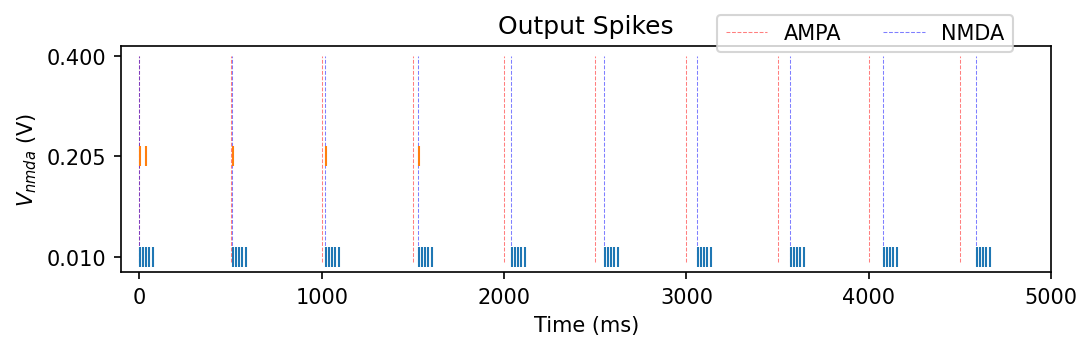

In [16]:
output_spikes = {}

network.restore()
dict_vmem = {}
dict_imem = {}
dict_inmda = {}
dict_out_spikes = {}

# Sweep V_nmda threshold values:
sampled_nmda = np.linspace(10, 400, 3).astype(int) #150
    
# Input parameters: ===============================================================================================================
dynapse_param["I_tau_syn_nmda"] = 1 *pA #.5
dynapse_param["I_tau_syn_ampa"] = 10 *pA         
dynapse_param['Itau'] = 10 *pA
dynapse_param["I_g_syn_nmda"] = dynapse_param["I_tau_syn_nmda"]
dynapse_param["I_g_syn_ampa"] = dynapse_param["I_tau_syn_ampa"] 
dynapse_param['I_wo_syn_nmda'] = 10*nA # chosen based on the DP characteristic                                                                                     
dynapse_param['I_wo_syn_ampa'] = 6 * nA # chosen based on the delta v
EPSC_nmda = dynapse_param['I_wo_syn_nmda']*dynapse_param['I_g_syn_nmda']/(dynapse_param["I_tau_syn_nmda"]*((dynapse_param["I_g_syn_nmda"]/constants.Io)+1))
# =================================================================================================================================

for vnmda in sampled_nmda:
    print('Vnmda: ', vnmda)
    dynapse_param['Vnmda'] = vnmda*mV
        
    for core in chip.cores:
        set_params(core.neurons, dynapse_param)
        
    # Simulation
    duration = inp_duration * 1000 * ms

    # Run
    network.run(duration)
    
    dict_inmda[vnmda] = (mon_neuron_I_syn_nmda.t/ms, mon_neuron_I_syn_nmda.I_syn_nmda_dp[0])
    dict_imem[vnmda] = (mon_neuron_state.t/ms, mon_neuron_state.Imem[0])
    dict_vmem[vnmda] = (mon_neuron_vmem.t/ms, mon_neuron_vmem.Vmem[0])
    dict_out_spikes[vnmda] = mon_neuron_output.t/ms
    # (The next one does not depend on Vnmda)
    iampa = (mon_synapse_ampa.t/ms, mon_synapse_ampa.I_syn_ampa[0])
    
    network.restore()
    
# Plot output spikes:
f = plt.figure(figsize=(8,2),dpi=150)
plt.subplot(111)
for i, vnmda in enumerate(sampled_nmda):
    spike_times = dict_out_spikes[vnmda]
    plt.plot(spike_times, [vnmda*mV]*len(spike_times), '|', c=colors[i], markersize=10)
plt.yticks(sampled_nmda*1e-3)
plt.xlim(-100, duration/ms)
plt.xlabel('Time (ms)')
plt.ylabel('$V_{nmda}$ (V)')
plt.title('Output Spikes')
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=.5, label='AMPA')
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=.5, label='NMDA')
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.8, 1.18))

# For each pair of input ISI, label the pair of input spike with True if an output spike was generated. 
mask_out_spike = {}
for nmda in sampled_nmda:
    
    mask_out_spike[nmda] = np.zeros(len(spike_timing_ampa))
    # Loop over the spike times of the AMPA synapse
    for ii, t_ampa in enumerate(spike_timing_ampa/ms):
        # If any output spike is recorded during that time window:
        if len(np.where( np.logical_and( dict_out_spikes[nmda]>=t_ampa, dict_out_spikes[nmda]<(t_ampa+1/rate*1e3) ) )[0])>0:
            mask_out_spike[nmda][ii]=1

### Plot

10
205
400


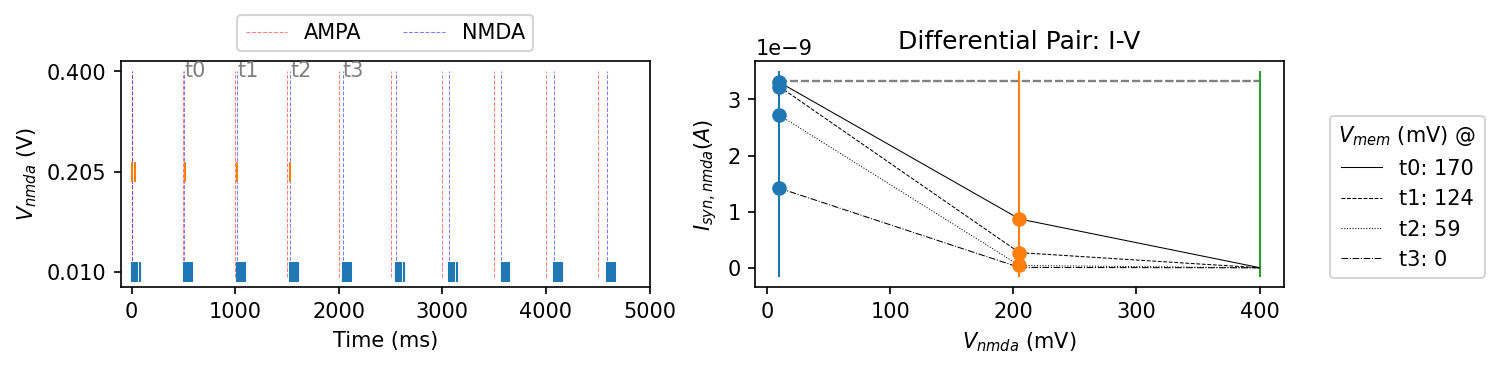

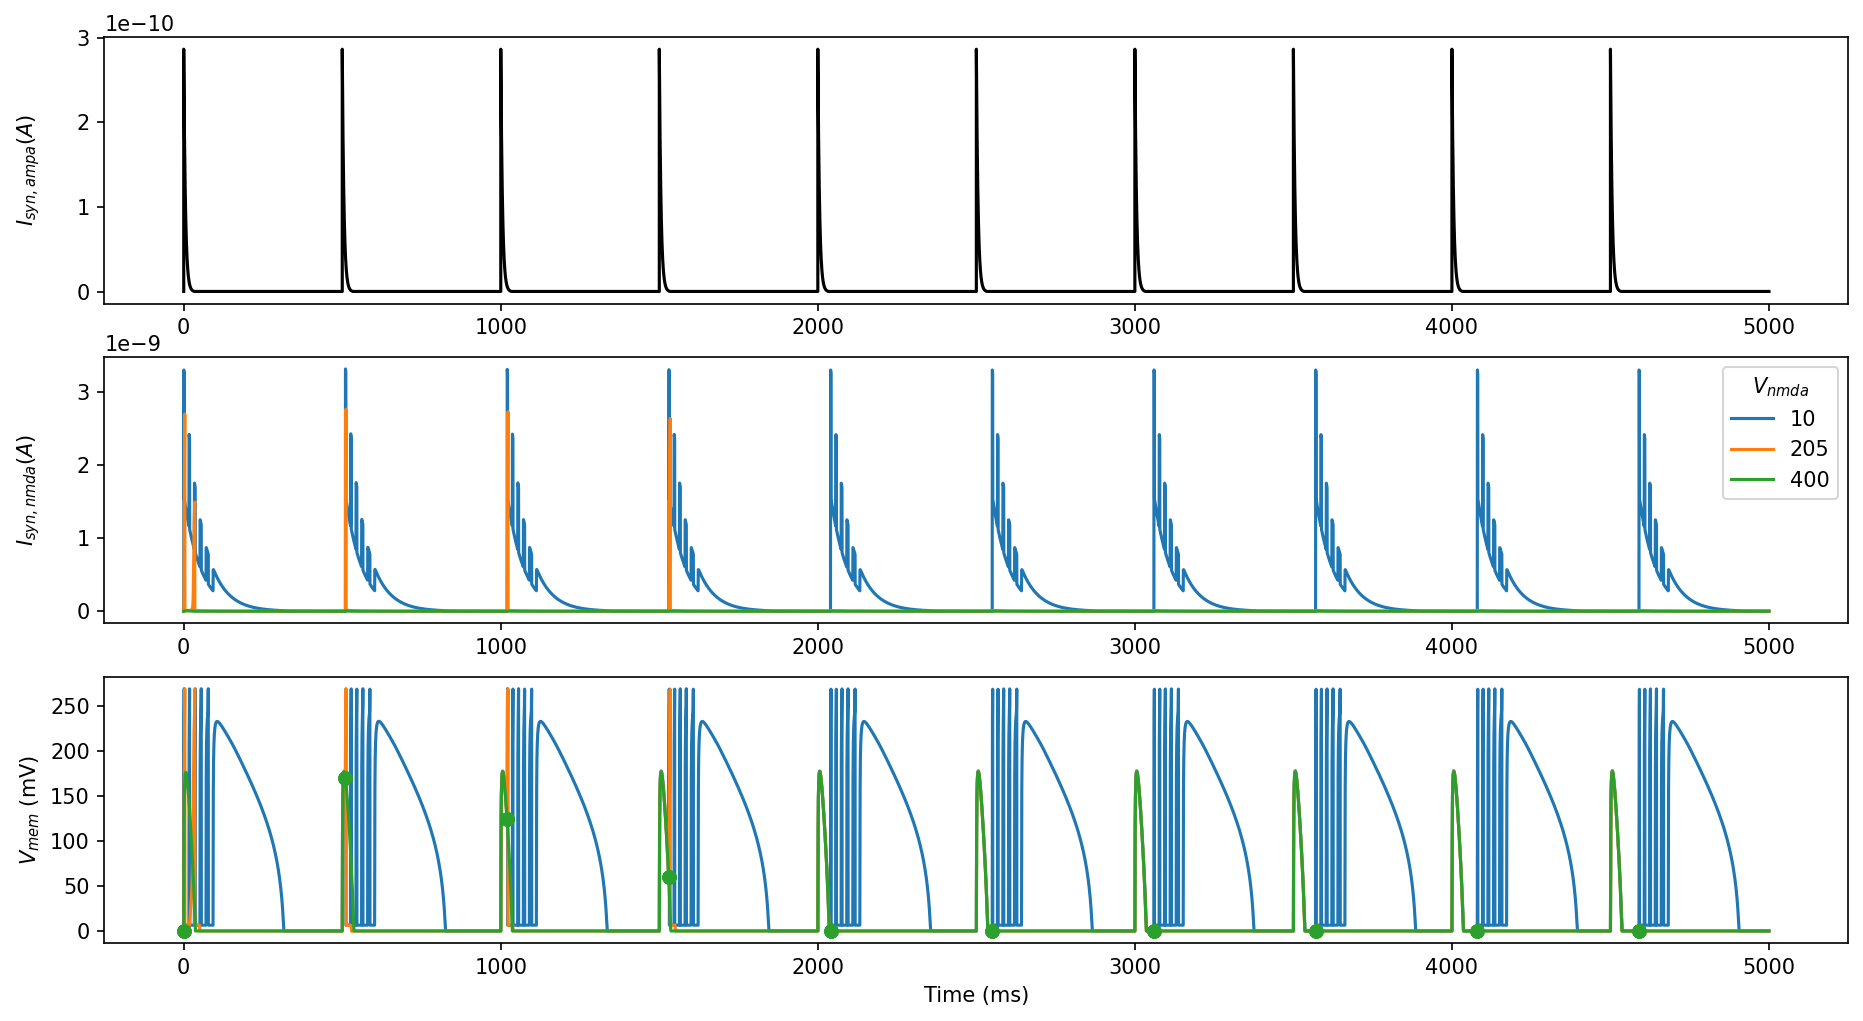

In [19]:
# Plot output spikes:
f = plt.figure(figsize=(10,2),dpi=150)

# Rasterplot
plt.subplot(121)
for i, vnmda in enumerate(sampled_nmda):
    spike_times = dict_out_spikes[vnmda]
    plt.plot(spike_times, [vnmda*mV]*len(spike_times), '|', c=colors[i], markersize=10)
plt.yticks(sampled_nmda*1e-3)
plt.xlim(-100, duration/ms)
plt.xlabel('Time (ms)')
plt.ylabel('$V_{nmda}$ (V)')
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=.5, label='AMPA')
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=.5, label='NMDA')
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(.5, 1.25))

input_isi = spike_timing_nmda[1:5]-spike_timing_ampa[1:5]
for ii, isi in enumerate(input_isi):
    plt.text(spike_timing_nmda[1+ii]/ms, ylim[-1]-.01, 't'+str(ii), c='grey')
    
# DPI Characteristics
I_syn = EPSC_nmda
plt.subplot(122)
style = ['solid', 'dashed', 'dotted', 'dashdot']

# Range Vmem
t_vmem = dict_vmem[list(dict_vmem.keys())[0]][0]
vmem = dict_vmem[list(dict_vmem.keys())[0]][1]
idx_vmem_at_nmda = [np.where(t_vmem<=t_nmda)[0][-1] for t_nmda in spike_timing_nmda/ms]
vmem_at_nmda = vmem[idx_vmem_at_nmda]/mV

# I-Vnmda curves for a range of vmem values
for v, vmem in enumerate(vmem_at_nmda[1:5]):
    vmem = vmem*mV
    i_syn_nmda = I_syn/(1 + np.exp(constants.kappa_n*(sampled_nmda*mV-vmem)/constants.Ut))
    p = plt.plot(sampled_nmda, i_syn_nmda/nA*1e-9, linestyle=style[v],c='k', linewidth=.5, label='t'+str(v)+': '+str(int(vmem/mV)))
    plt.hlines(y=I_syn/nA*1e-9, xmin=sampled_nmda[0], xmax=sampled_nmda[-1], linestyle='--', color='grey', linewidth=1)

ylim = plt.ylim()
for i, vnmda in enumerate(sampled_nmda):
    plt.vlines(vnmda, ylim[0], ylim[1], linestyle='-', color=colors[i], linewidth=1)

plt.legend(loc='right', ncol=1, bbox_to_anchor=(1.4, 0.4), title='$V_{mem}$ (mV) @')
plt.xlabel('$V_{nmda}$ (mV)')
plt.ylabel('$I_{syn,nmda} (A)$')
plt.title('Differential Pair: I-V')

# Label intersection between DP characteristic and Vnmda if an output spike was generated:
for vv, vmem in enumerate(vmem_at_nmda[1:5]):
    for nn, vnmda in enumerate(sampled_nmda):
        if mask_out_spike[vnmda][vv+1]==1: # +1 because we are skipping the first input pair of spikes
            i_syn_nmda = I_syn/(1 + np.exp(constants.kappa_n*(vnmda-vmem)*mV/constants.Ut))
            plt.plot(vnmda, i_syn_nmda, 'o', c=colors[nn])
            
# Plot Vmem, EPSC AMPA, and EPSC NMDA as a function of Vnmda
f = plt.figure(figsize=(15,8),dpi=150)
plt.subplot(3,1,1)
plt.plot(iampa[0], iampa[1], c='k')
plt.ylabel('$I_{syn,ampa} (A) $')
plt.subplot(3,1,2)
for vnmda in sampled_nmda:
    plt.plot(dict_inmda[vnmda][0], dict_inmda[vnmda][1], label=str(vnmda))
    print(vnmda)
plt.legend(title='$V_{nmda}$')
plt.ylabel('$I_{syn,nmda} (A) $')
plt.subplot(3,1,3)

for vnmda in sampled_nmda:
    plt.plot(dict_vmem[vnmda][0], dict_vmem[vnmda][1]/mV)
    plt.plot(spike_timing_nmda/ms,vmem_at_nmda, 'o', c=colors[len(sampled_nmda)-1])

plt.ylabel('$V_{mem}$ (mV)')
plt.xlabel('Time (ms)')

f.align_ylabels()

* $V_{nmda}$ = 400 mV: no output spike. Gating threshold too large, i.e. $I_{syn,nmda}$ too small (see DP I-V characterstic plot)
* $V_{nmda}$ = 205 mV: the coincidence detector **fires every time the NMDA input spike follows the AMPA spike within a 'short time window'**, i.e. when the inter-spike-interval falls within a time window comparable to the AMPA EPSC timescale.
* $V_{nmda}$ = 10 mV: the neuron fires at every NMDA input spike, i.e. gating threshold too low. 